In [1]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
os.environ['CUDA_VISIBLE_DEVICES'] = "7"

fish-gcp005
/home/akarshkumar0101/nca-alife/src
/home/akarshkumar0101/miniconda3/envs/nca-alife-jax/bin/python


In [2]:
import os, sys, glob, pickle
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

In [3]:
import jax
import jax.numpy as jnp
from jax.random import split

import flax
import flax.linen as nn
from flax.training.train_state import TrainState

import optax

In [4]:
# https://www.youtube.com/watch?v=scvuli-zcRc&t=3s

In [246]:
n_colors = 6
n_dims = 2

# dt = 0.02
dt = 0.002
half_life = 0.04
rmax = 0.1

# NOTE: the actual space is [0, 1]

def get_random_env_params(rng):
    beta = 0.3
    # alphas = jax.random.normal(rng, (n_colors, n_colors))
    alphas = jax.random.uniform(rng, (n_colors, n_colors), minval=-1., maxval=1.)
    masses = jnp.ones((n_colors, ))/10.
    return dict(alphas=alphas, beta=beta, masses=masses)

def calc_force(r, alpha, beta):
    first = r / beta - 1
    second = alpha * (1 - jnp.abs(2 * r - 1 - beta) / (1 - beta))
    cond_first = (r < beta) # (0 <= r) & (r < beta)
    cond_second = (beta < r) & (r < 1)
    return jnp.where(cond_first, first, jnp.where(cond_second, second, 0.))

def get_random_init_state(rng):
    rng, _rng = split(rng)
    c = jax.random.randint(_rng, (n_particles,), 0, n_colors)
    rng, _rng = split(rng)
    x = jax.random.uniform(_rng, (n_particles, n_dims), minval=0, maxval=1)
    v = jnp.zeros((n_particles, n_dims))
    return dict(c=c, x=x, v=v)

def forward_step(rng, state, env_params):
    x, v, c = state['x'], state['v'], state['c']
    alphas, beta, masses = env_params['alphas'], env_params['beta'], env_params['masses']

    mass = masses[c]

    # index alphas using all pairwise colors, code looks weird, but works
    alpha = alphas[c[:, None], c[None, :]] # (N, N)
    r = x[None, :, :] - x[:, None, :] # (N, N, D)
    r = jnp.minimum(r, 1.-r) # circular boundary
    
    # print(r[2, 4], (x[4] - x[2]))
    # print(alpha[2,4], alphas[c[2], c[4]])
    rlen = jnp.linalg.norm(r, axis=-1)

    # double vmap for pairwise (N, N) interactions
    f = jax.vmap(jax.vmap(partial(calc_force, beta=beta)))(rlen/rmax, alpha)
    f = r/(rlen[..., None]+1e-8) * f[..., None]
    # f = f.at[jnp.arange(n_particles), jnp.arange(n_particles)].set(0.) # uneeded if adding epsilon term
    
    f = rmax * jnp.sum(f, axis=1)
    acc = f / mass[:, None]
    
    mu = (0.5) ** (dt / half_life)
    v = mu * v + acc * dt
    x = x + v * dt

    x = x%1. # circular boundary
    return dict(c=c, x=x, v=v)

def render_state(state):
    x, v, c = state['x'], state['v'], state['c']
    for ci in range(n_colors):
        plt.scatter(*x[c==ci].T, s=1.)
    plt.xlim(-0.0, 1.0)
    plt.ylim(-0.0, 1.0)

In [247]:
rng = jax.random.PRNGKey(1)
env_params = get_random_env_params(rng)

state = get_random_init_state(rng)

state = forward_step(rng, state, env_params)

  0%|          | 0/16 [00:00<?, ?it/s]

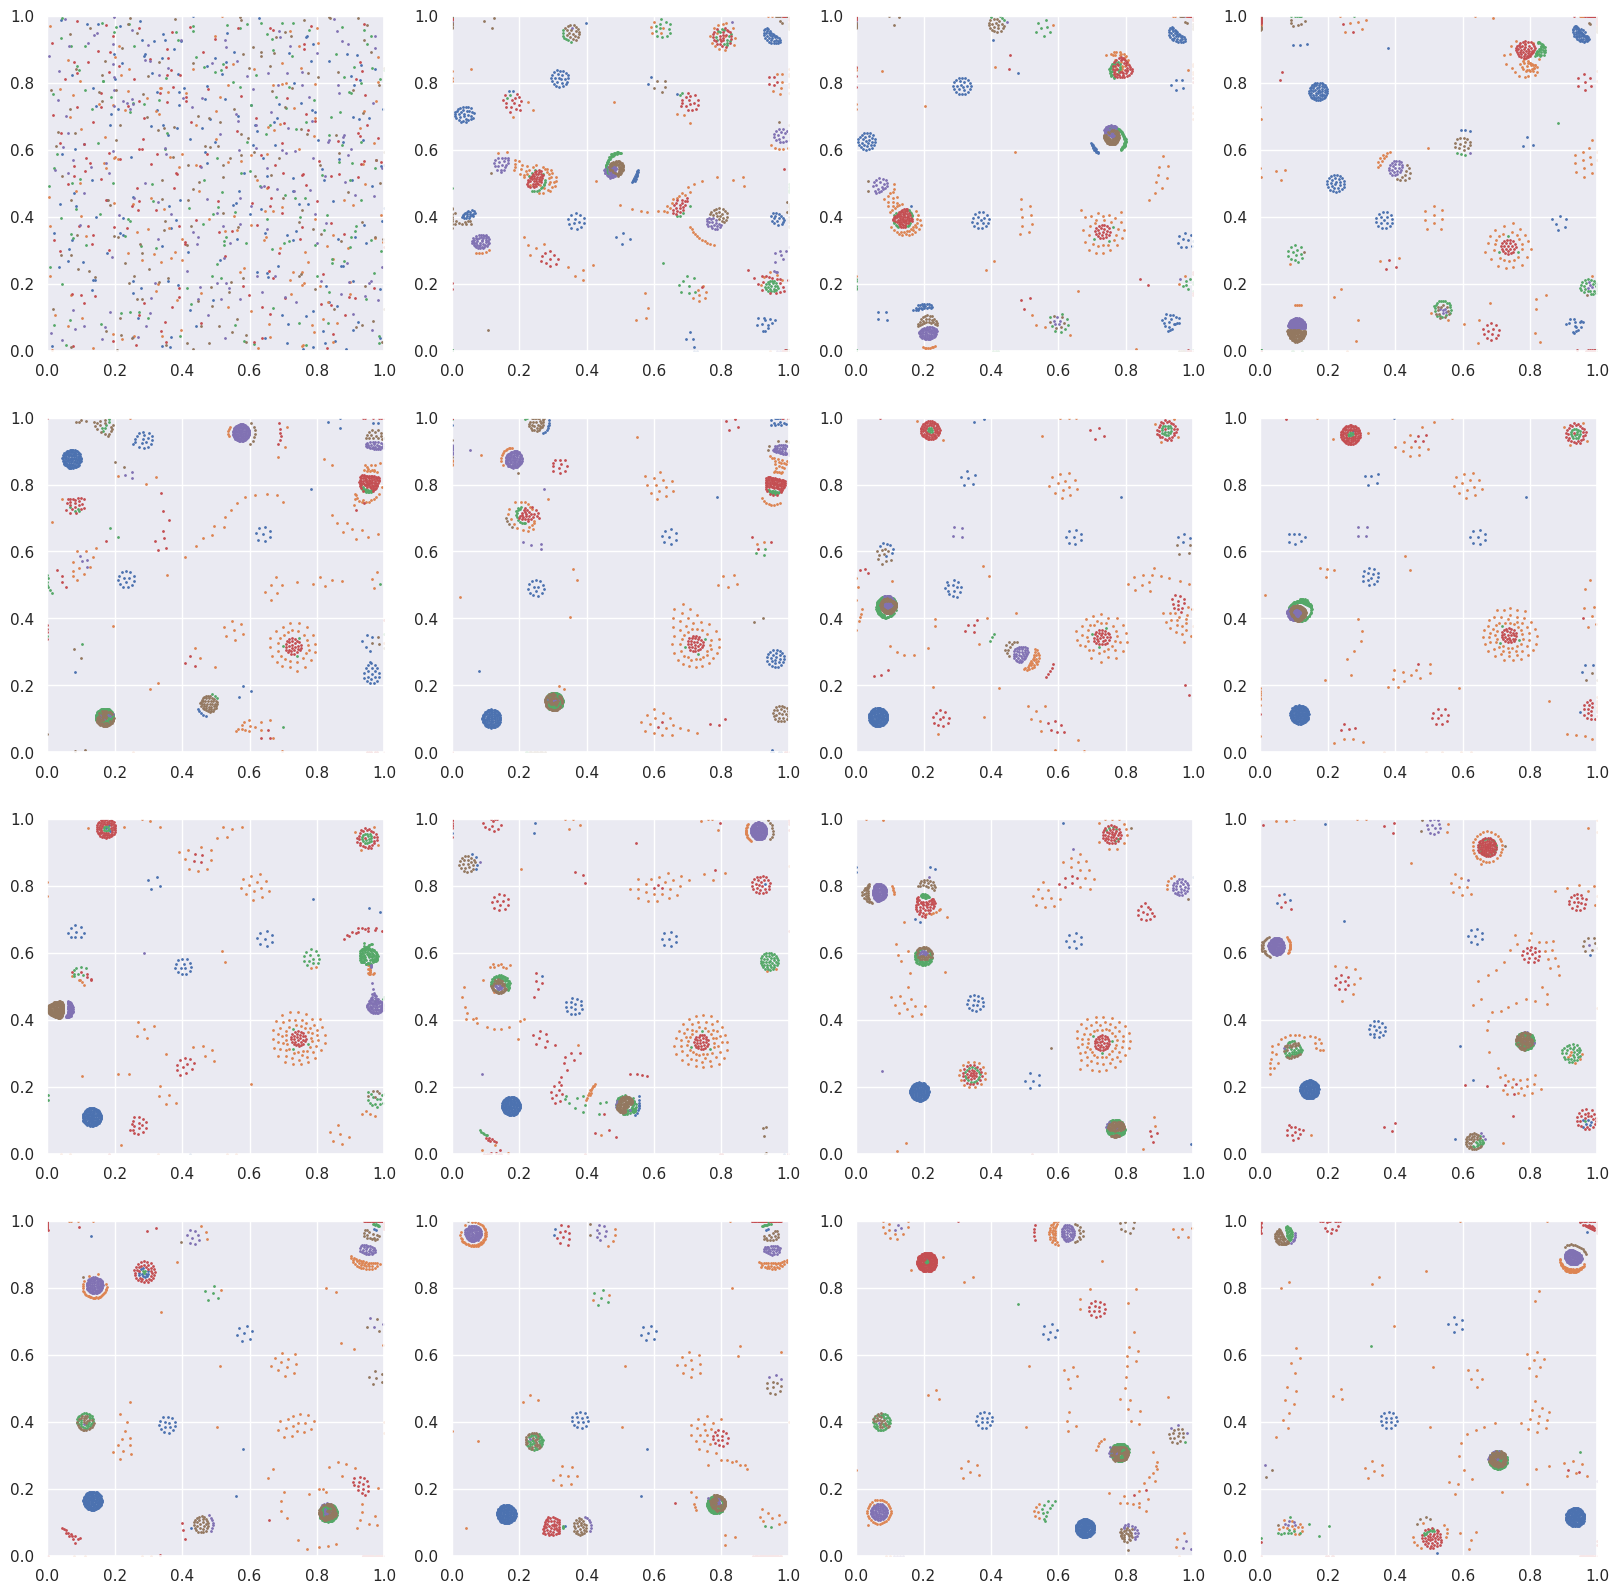

In [248]:
rng = jax.random.PRNGKey(0)
rng, _rng = split(rng)
env_params = get_random_env_params(_rng)

rng, _rng = split(rng)
state = get_random_init_state(_rng)

@jax.jit
def forward_step_mine(state, _):
    state = forward_step(None, state, env_params)
    return state, state


plt.figure(figsize=(20, 20))
for i in tqdm(range(16)):
    plt.subplot(4, 4, i+1)
    render_state(state)
    state, vid = jax.lax.scan(forward_step_mine, state, length=10000)


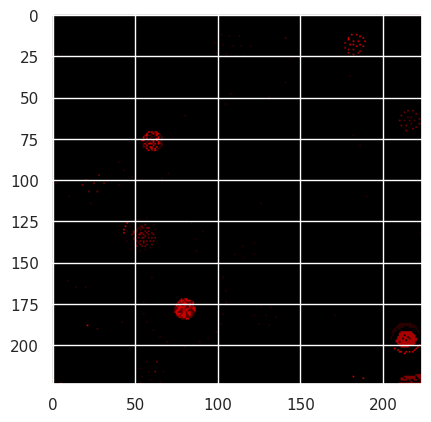

In [262]:
def render_state(state, img_size=224):
    x, v, c = state['x'], state['v'], state['c']
    img = jnp.zeros((img_size, img_size, 3))

    idx = (x*img_size).astype(int)
    img = img.at[idx[:, 0], idx[:, 1], 0].set(c/n_colors)
    
    return img

img = render_state(state)
plt.imshow(img)


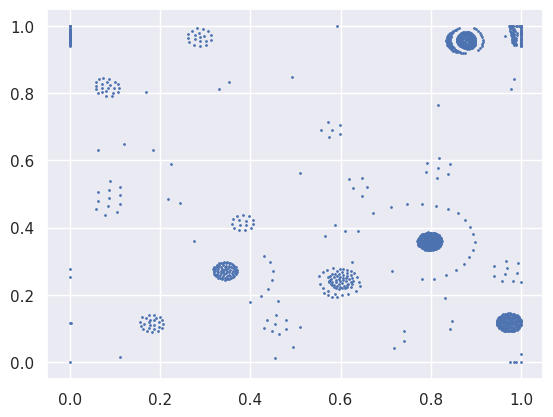

In [257]:
plt.scatter(*state['x'].T, s=1.)

In [231]:
jax.tree.map(lambda x: x.shape, vid)

{'c': (10000, 1000), 'v': (10000, 1000, 2), 'x': (10000, 1000, 2)}

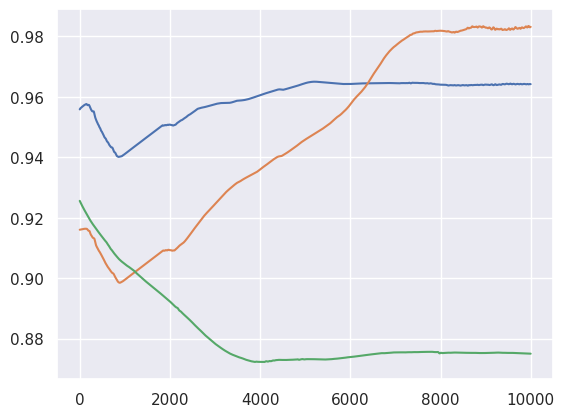

In [242]:
plt.plot(vid['x'][:, :3, 0])

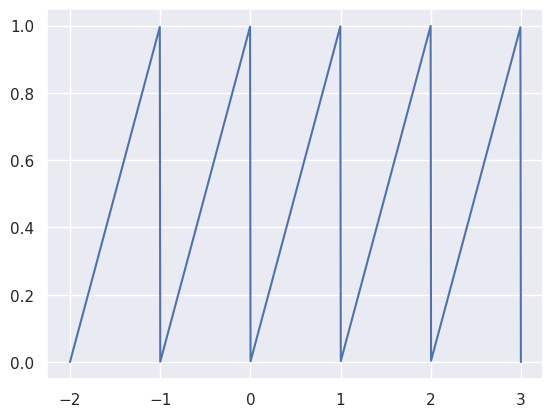

In [264]:
x = jnp.linspace(-2, 3, 1000)
y = x%1
plt.plot(x, y)

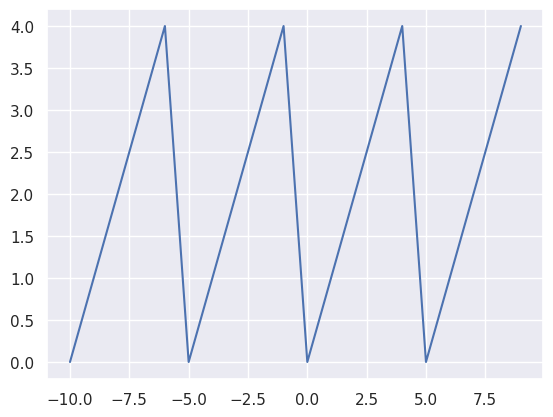

In [266]:
x = jnp.arange(-10, 10)
y = x%5
plt.plot(x, y)

[[-0.         -0.32587138 -0.11319419 -0.2517466  -0.39370623]
 [-0.2581752  -0.          0.33277568 -0.16534513  0.23724943]
 [ 0.11319419 -0.33277568 -0.         -0.00355801  0.7916105 ]
 [ 0.2517466  -0.20870033 -0.00449096 -0.         -0.21128696]
 [-0.09780009  0.07047719  0.23515536 -0.05248553 -0.        ]]


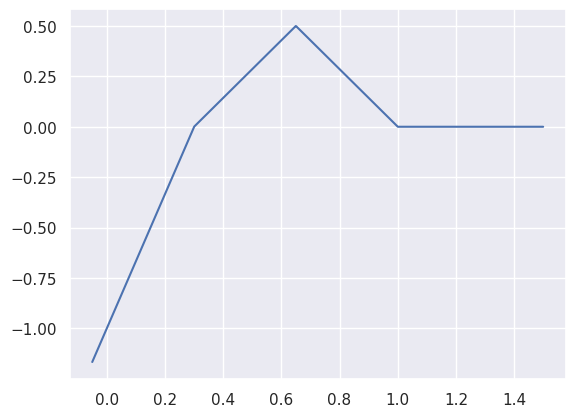

In [91]:
x = jnp.linspace(-0.05, 1.5, 1000)
y = jax.vmap(partial(calc_force, alpha=0.5, beta=0.3))(x)
plt.plot(x, y)

In [35]:
def temp(state, _rng):
    state = forward_state(_rng, state, env_params)
    return state, None


a, _ = jax.lax.scan(temp, state, split(rng, 1000000))

In [36]:
a['x'].max()

Array(6849.4443, dtype=float32)

  0%|          | 0/1000 [00:00<?, ?it/s]

(1000,) (8, 8)
(1000, 1000)


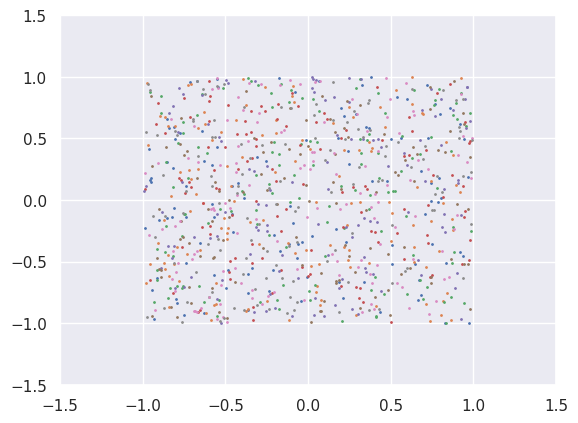

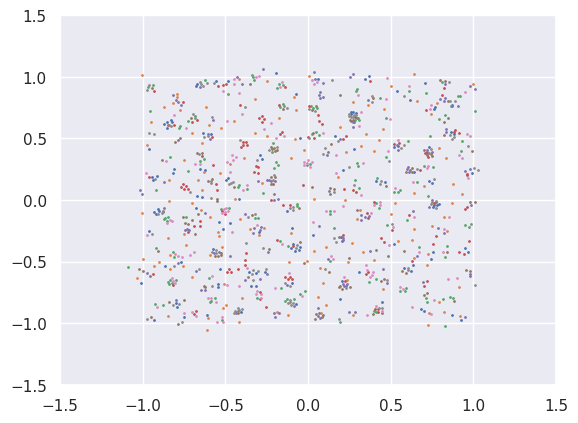

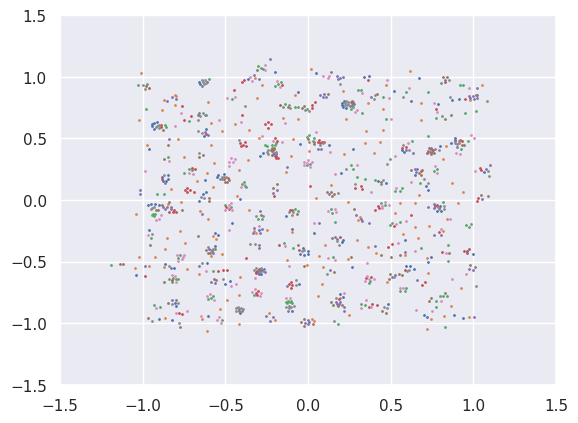

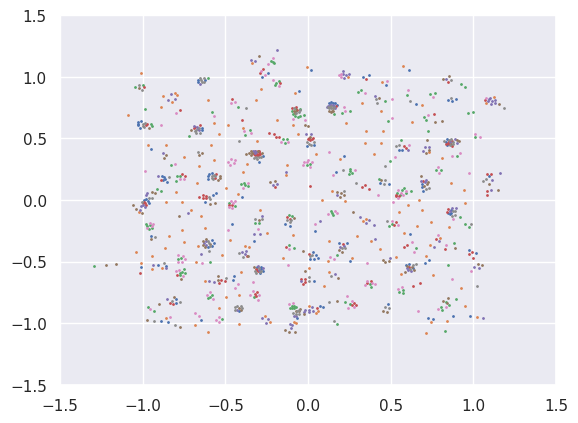

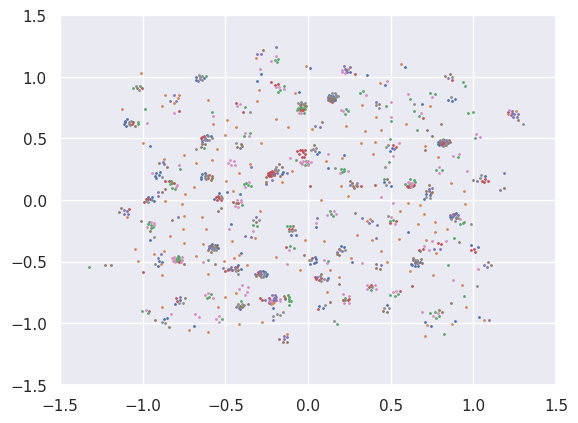

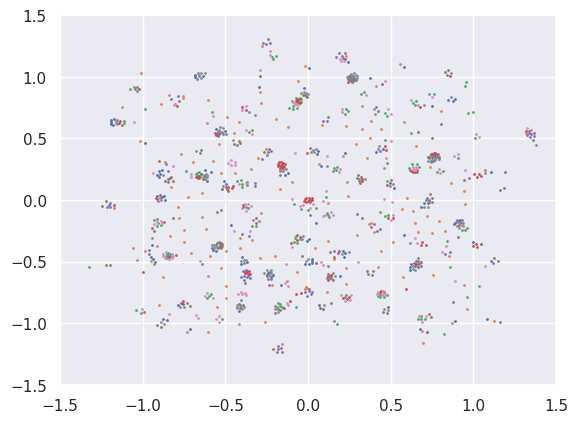

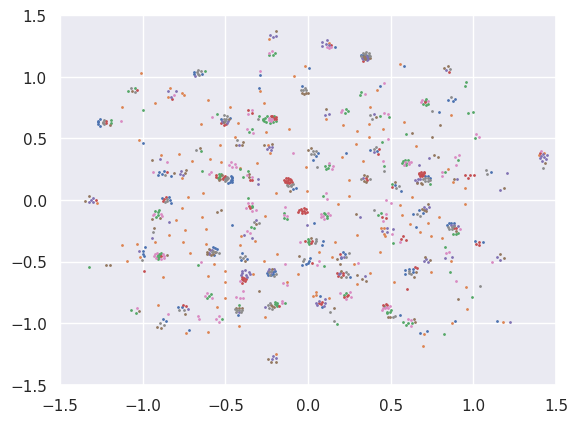

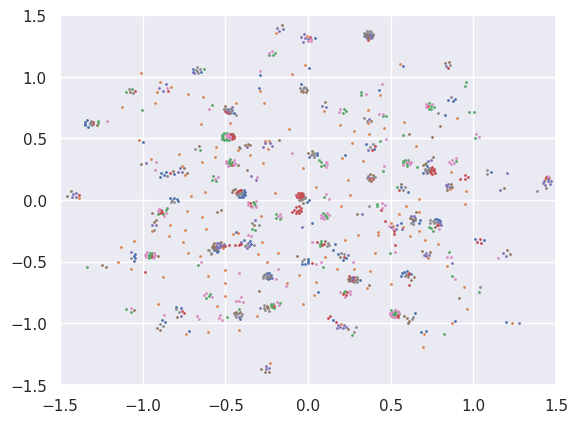

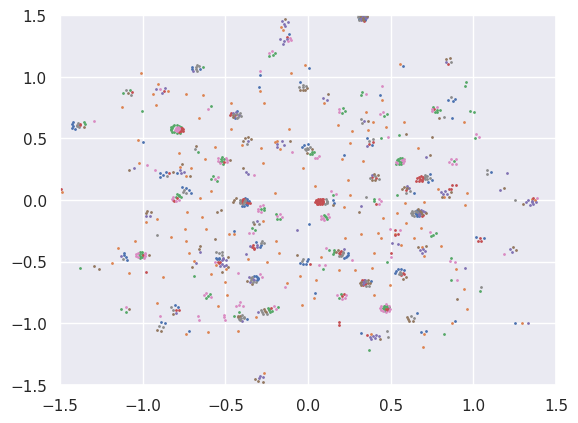

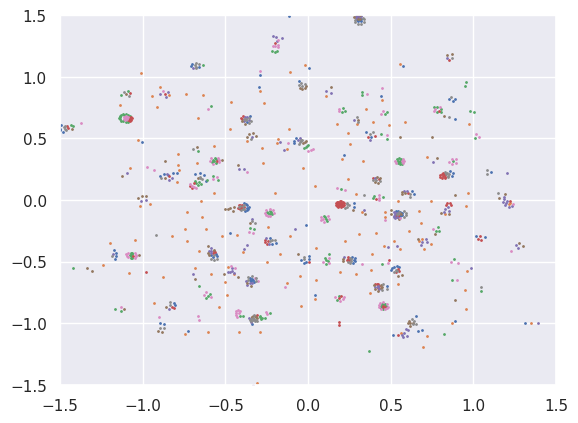

In [24]:
rng = jax.random.PRNGKey(1)

rng, _rng = split(rng)
env_params = init_env_params(_rng)
rng, _rng = split(rng)
state = init_state(_rng)

for i in tqdm(range(1000)):
    rng, _rng = split(rng)
    state = forward_state(_rng, state, env_params)
    if i % 100 == 0:
        render_state(state)
        plt.show()